## Happiness Score from the [World Happiness Report](https://worldhappiness.report/)
In this notebook we will use the 2023 "World Happiness Report" dataset. This dataset is based on the yearly Gallup World Poll which surveys around 100,000 people from 130 countries. The main metric is the Cantril ladder which asks respondents to think of a ladder and their standing on it with the best possible life for them being a 10 and the worst possible life being a 0. We select the five countries with the highest variance across the years 2008 to 2022 with respect to the Cantrill Ladder Score.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

The data website is linked [here](https://worldhappiness.report/data/). We use the latest information from 2023 under the name ["Data for Table 2.1"](https://happiness-report.s3.amazonaws.com/2023/DataForTable2.1WHR2023.xls). It contains the ladder score from 2008 to 2022.

In [2]:
df = pd.read_excel('../dat/DataForTable2.1WHR2023.xls')
df

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,Afghanistan,2008,3.723590,7.350416,0.450662,50.500000,0.718114,0.167652,0.881686,0.414297,0.258195
1,Afghanistan,2009,4.401778,7.508646,0.552308,50.799999,0.678896,0.190809,0.850035,0.481421,0.237092
2,Afghanistan,2010,4.758381,7.613900,0.539075,51.099998,0.600127,0.121316,0.706766,0.516907,0.275324
3,Afghanistan,2011,3.831719,7.581259,0.521104,51.400002,0.495901,0.163571,0.731109,0.479835,0.267175
4,Afghanistan,2012,3.782938,7.660506,0.520637,51.700001,0.530935,0.237588,0.775620,0.613513,0.267919
...,...,...,...,...,...,...,...,...,...,...,...
2194,Zimbabwe,2018,3.616480,7.783066,0.775388,52.625000,0.762675,-0.051219,0.844209,0.657524,0.211726
2195,Zimbabwe,2019,2.693523,7.697755,0.759162,53.099998,0.631908,-0.047464,0.830652,0.658434,0.235354
2196,Zimbabwe,2020,3.159802,7.596050,0.717243,53.575001,0.643303,0.006313,0.788523,0.660658,0.345736
2197,Zimbabwe,2021,3.154578,7.656878,0.685151,54.049999,0.667636,-0.075575,0.756945,0.609917,0.241682


In [3]:
# We extract a list of countries as these don't have information for every year so we need to query them individually
countries = np.array(list(set(df["Country name"])))
stds = []
for country in countries:
    std = df[df['Country name'] == country]['Life Ladder'].std(axis=0)
    stds.append(std)
stds = np.array(stds)

In [4]:
# Some countries only have data for one year, and their std is a nan value. We remove these from both the countries and stds list.
countries = countries[(stds==stds)]
stds = stds[(stds==stds)]
sorted_variance = np.argsort(stds)[::-1]

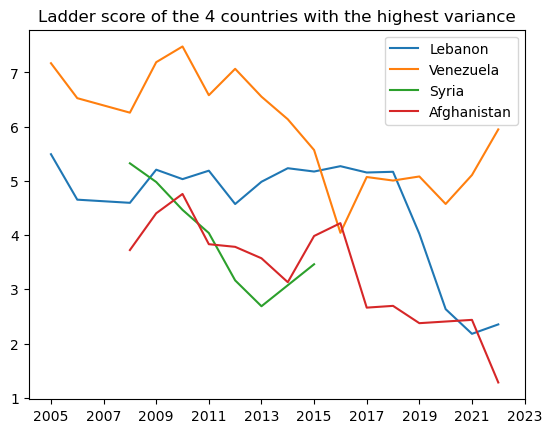

In [7]:
# We make plots of the estimated share of people in the countries with the highest variance in time for the corresponding illness
num_countries = 4
for i in range(num_countries):
    country = countries[sorted_variance[i]]
    
    # Group by 'Entity' (country) and calculate the mean percentage for each disorder
    ladder_score = df[df['Country name'] == country]['Life Ladder']
    years = df[df['Country name'] == country]['year']
    plt.plot(years, ladder_score, label=country)
    plt.title('Ladder score of the '+str(num_countries)+' countries with the highest variance')
plt.xticks(range(2005,2024)[::2])
plt.legend()
plt.savefig(str(num_countries)+"_ladder.png", dpi=300, bbox_inches='tight')